# Human body motion for in-home physiotherapy

In [1]:
import os
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import math
import seaborn as sns
import statistics as st
import glob

## 0. Getting started with OpenPose

link GitHub: GitHub - OpenKinect/libfreenect: Drivers and libraries for the Xbox Kinect device on Windows, Linux, and OS X
cd D:\Special_Project\openpose
bin\OpenPoseDemo.exe --image_dir examples\media\  --write_json output_json_folder/
* 1 file .json by images: --image_dir
* 1 file .json by video: --video

To use this script:
* Take several pictures of the same pose to define the reference position
Plot all images of the virtual space on the same figure in "3. Virtual space". You can verify that you have the same pose and you can assess the distribution of positions/angles
* Choose if you want to study the "reduced" data set, or the whole dataset of joints.
Computing every joint's distribution is not always a good idea, you can display only the members you want by choosing the limb "limb1-limb2'and the associated description [n°1 - n°2]
* Define the generative model. Run the "5. or 6. reference model"
* Run on the new data, don't forget to pass in argument the reference dataframe on which you trained the generative model


## 1. Read the output

In [13]:
#---------------------------- Define by user ----------------------------#
def path_file(repository, file):
    path = os.path.join(repository, file)
    return path
#------------------------------------------------------------------------#

In [9]:
path_data ='D:\Special_Project\openpose\output_json_folder\Train\Ludo'
file_data ='WIN_20220928_09_32_59_Pro_keypoints.json'

In [10]:
path_json=path_file(path_data,file_data)
#Open the json
fObj = open(path_json)
#Transform the json into dictionnary
ogdata = json.load(fObj)
#Transform the dict into list
list_data = [ogdata["people"][i]["pose_keypoints_2d"] for i, elem in enumerate(ogdata["people"])]
list_data = list_data[0]

NameError: name 'path_file' is not defined

In [5]:
path_wrong = 'D:\Special_Project\Dataset\Output\Wrong_file'
wrong_file = 'WIN_20221120_16_26_24_Pro_Trim_000000000041_keypoints.json'
path_json=path_file(path_wrong,wrong_file)
#Open the json
fObj = open(path_json)
#Transform the json into dictionnary
ogdata = json.load(fObj)
#Transform the dict into list
list_data = [ogdata["people"][i]["pose_keypoints_2d"] for i, elem in enumerate(ogdata["people"])]
list_data = list_data[0]

In [30]:
def extract_coord_nb_pers(path, filename, nb_pers):
    '''
    INPUT:
    path: path to the file
    filename: name of the file
    nb_pers: define if you have more than 1 pers, nb_pers = nb de person - 1

    list_coord: list of tuple (x,y,c)  
    '''
    path_json = path_file(path,filename)
    fObj = open(path_json)
    ogdata = json.load(fObj)
    list = [ogdata["people"][i]["pose_keypoints_2d"] for i, elem in enumerate(ogdata["people"])]
    list_coord=[(list[nb_pers][i], list[nb_pers][i+1], list[nb_pers][i+2]) for i, elem in enumerate(list[nb_pers]) if ((i%3==0) and (i<75))]
    return list_coord

def x_y_c(list_x_y_c):
    '''
    list_coord: list of coordinate x,y and confidence parameter c
    '''
    list_x = [(list_x_y_c[i][0]) for i, elem in enumerate(list_x_y_c) ]
    list_y = [(list_x_y_c[i][1]) for i, elem in enumerate(list_x_y_c) ]
    list_c = [(list_x_y_c[i][2]) for i, elem in enumerate(list_x_y_c) ]

    return list_x, list_y, list_c

def trace(X,Y,C, list_bp, color):
    '''  
    Plot the coordinates contained in the dataframe X,Y
    Originally, the size of the dot was related to the confidence found by OpenPose.
    It is not used in this algorithm any longer
    
    '''
    
    for i,elem in enumerate(list_bp):
        plt.plot([X[elem[0]], X[elem[1]]],  [Y[elem[0]], Y[elem[1]]] , color=str(color))

In [32]:
def list_XY_err(list_bp, X, Y, color):
    '''   
    Takes the coordinate of the dataframe X and Y and thanks to list_bp (list of body part),
    the angles of each limb are defined in regards to the vertical axis
    '''
    i_ref = [0,1] 

    vect_bp = [[X[elem[1]] - X[elem[0]], Y[elem[1]] - Y[elem[0]]] for i, elem in enumerate(list_bp)]
    angle_cos = [np.dot(np.asarray([el[0], el[1]]), i_ref)/math.sqrt(el[0]**2+ el[1]**2) for i, el in enumerate(vect_bp)]
    angle_sin = [np.cross(np.asarray([el[0], el[1]]), i_ref)/math.sqrt(el[0]**2+ el[1]**2) for i, el in enumerate(vect_bp)]
    
    return vect_bp, angle_cos, angle_sin


def angle(angle_cos, angle_sin):
    """   
    This function allows to relate the angle to the right joint.
    If your joint is on the right side, the angle sin and cos will have a certain value, 
    if the joint is at the opposite side (left), you will have another value
    Then the left joints have positive values and the right joints have negative values
    """
    theta = []
    for i in range(len(angle_cos)):
        angle = math.acos(angle_cos[i])*180/math.pi
        if angle_cos[i]>=0 and angle_sin[i]>=0:
            theta.append(angle)
        elif angle_cos[i]<=0 and angle_sin[i]>=0:
            theta.append(angle)
        elif angle_cos[i]>=0 and angle_sin[i]<=0:
            theta.append(-1*angle)
        elif angle_cos[i]<=0 and angle_sin[i]<=0:
            theta.append(-1*angle)
    return theta

def angle_joints(list_bp, angle):
    """   
    This part allows to construct a dicitonnary of angles in reards with the list_bp (list of body part)
    """
    dicts={}
    keys = list_bp
    values = angle
    for i in range(len(keys)):
        dicts[str(keys[i])] = values[i]
    return dicts 

In [4]:
def list_files(directory, suffix, boolean):
    '''
    Select all the files and exclude the one starting with special str


    Parameters
    ----------
    directory : str
        path containing the files
    suffix : str
        check if endswith the str


    Returns
    -------
    it : list
        List of files 

    '''

    saved = os.getcwd()
    os.chdir(directory)
    it = glob.glob(suffix, recursive = boolean)
    it = [i[:] for i in it]
    os.chdir(saved)
    return it

## 2. Define the link between the index in the json and the joint

Initialization step

In [5]:
annotation_dict = {
     "Nose": 0,
     "Neck": 1,
     "RShoulder": 2,
     "RElbow":  3,
     "RWrist": 4,
     "LShoulder": 5,
     "LElbow": 6,
     "LWrist": 7,
     "MidHip": 8,
     "RHip": 9,
     "RKnee": 10,
     "RAnkle": 11,
     "LHip": 12,
     "LKnee": 13,
     "LAnkle": 14,
     "REye": 15,
     "LEye": 16,
     "REar": 17,
     "LEar": 18,
     "LBigToe": 19,
     "LSmallToe": 20,
     "LHeel": 21,
     "RBigToe": 22,
     "RSmallToe": 23,
     "RHeel": 24,
     #{"Background": "25"}
}

Different tools to describe the data: dict, df

In [6]:
annotation_list  = [annotation_dict[k] for k,i in annotation_dict.items()]
body_parts = annotation_dict.keys() #dict_keys
print(body_parts)

dict_keys(['Nose', 'Neck', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist', 'MidHip', 'RHip', 'RKnee', 'RAnkle', 'LHip', 'LKnee', 'LAnkle', 'REye', 'LEye', 'REar', 'LEar', 'LBigToe', 'LSmallToe', 'LHeel', 'RBigToe', 'RSmallToe', 'RHeel'])


In [14]:
list_coord = extract_coord_nb_pers(path_data,file_data, 0)
df_bp=pd.DataFrame(list_coord , annotation_dict.keys(), columns=['x', 'y', 'c'])
print(df_bp.head())


                 x         y         c
Nose       592.227  108.2350  0.907855
Neck       598.057  176.8430  0.882754
RShoulder  543.129  176.7690  0.810912
RElbow     460.844  133.6700  0.825104
RWrist     380.563   74.9353  0.862330


In [15]:
# Define the joints for different parts, upper, lower, head and feet

upper_joint = ['Nose-Neck', 'Neck-LShoulder', 'LShoulder-LElbow', 'LElbow-LWrist', 'Neck-RShoulder', 'RShoulder-RElbow', 'RElbow-RWrist', 'Neck-MidHip']
head_joint = ['REye-Rear', 'LEye-LEar', 'Nose-REye', 'Nose-LEye']
lower_joint = ['MidHip-RHip', 'MidHip-LHip', 'RHip-RKnee','RKnee-RAnkle', 'LHip-LKnee', 'LKnee-LAnkle']
feet_joint = ['RAnkle-RHeel', 'Rankle-RBigToe', 'RBigToe-RSmallToe', 'LAnkle-LHeel', 'LAnkle-LBigToe', 'LBigToe-LSmallToe']

upper = [[0,1], [1,5], [5,6], [6,7], [1,2], [2,3], [3,4], [1,8]]
head = [[15,17], [16,18], [0,15], [0,16]]
lower = [[8,9], [8,12], [9,10], [10,11], [12,13], [13,14]]
feet = [[11,24], [11,22], [22,23], [14,21], [14,19], [19,20]]
background = [[25, 25]]


bp_joint = upper_joint + head_joint + lower_joint + feet_joint
coor_bp = upper + head + lower + feet 

# Dictionnary of with the n° and name of joint-vector
dict_joint_position =  {bp_joint[i]: coor_bp[i] for i in range(len(bp_joint))} 


In [16]:
print(dict_joint_position.keys())

dict_keys(['Nose-Neck', 'Neck-LShoulder', 'LShoulder-LElbow', 'LElbow-LWrist', 'Neck-RShoulder', 'RShoulder-RElbow', 'RElbow-RWrist', 'Neck-MidHip', 'REye-Rear', 'LEye-LEar', 'Nose-REye', 'Nose-LEye', 'MidHip-RHip', 'MidHip-LHip', 'RHip-RKnee', 'RKnee-RAnkle', 'LHip-LKnee', 'LKnee-LAnkle', 'RAnkle-RHeel', 'Rankle-RBigToe', 'RBigToe-RSmallToe', 'LAnkle-LHeel', 'LAnkle-LBigToe', 'LBigToe-LSmallToe'])


In [17]:
print(annotation_dict.keys())

dict_keys(['Nose', 'Neck', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist', 'MidHip', 'RHip', 'RKnee', 'RAnkle', 'LHip', 'LKnee', 'LAnkle', 'REye', 'LEye', 'REar', 'LEar', 'LBigToe', 'LSmallToe', 'LHeel', 'RBigToe', 'RSmallToe', 'RHeel'])


### Tools

Annotation dictionary: link between the numero of the output of the json file and the type of joint
Dictionary joint position: link between the numero of the output of the json file and the type of limb

# 3. Virtual space

In [24]:
# Define the path to the image in the background 

path_im = 'D:\Special_Project\Dataset\Perso\Calibration\Train\Ludo'
file_image_wall = 'WIN_20220928_09_32_59_Pro.jpg'
path_2_json ='D:\Special_Project\Dataset\Output\Show\Trim'
path_image_wall = path_file(path_im,file_image_wall)
path_img_json = [path_image_wall , path_2_json]

In [26]:
def X_Y_C_virtual_space(path, annotation_list, nb_pers):
    '''    
    This function extracts the coordinates of one or several files .json
    It plots the result over the same image/virtual space.
    This allows to check that the position is the right one, and also we assess the distribution of angles.
    '''
    path_image_wall = path[0]
    path_2_json = path[1]
    image_wall = cv2.imread(path_image_wall)
    rows,cols,_ = image_wall.shape
    blank = np.zeros(image_wall.shape)

    for j,filename in enumerate(sorted(os.listdir(path_2_json), key=len)):
        list_coord = extract_coord_nb_pers(path_2_json,filename, nb_pers)
        X,Y,C = x_y_c(list_coord)
        for i, label in enumerate(annotation_list):
            plt.annotate(label, (X[i], Y[i]))

        trace(X,Y,C, coor_bp, color='b')
        plt.scatter(X, Y, color='red')
        plt.imshow(image_wall)
        plt.title('Coordinate of the joints on image wall')

        plt.figure(i, figsize=(13,15)) 
        plt.imshow(blank, cmap='gray')
        plt.title('Virtual space')
        trace(X,Y,C, coor_bp, color='b')

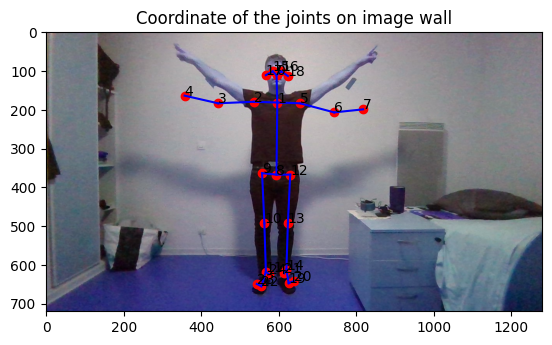

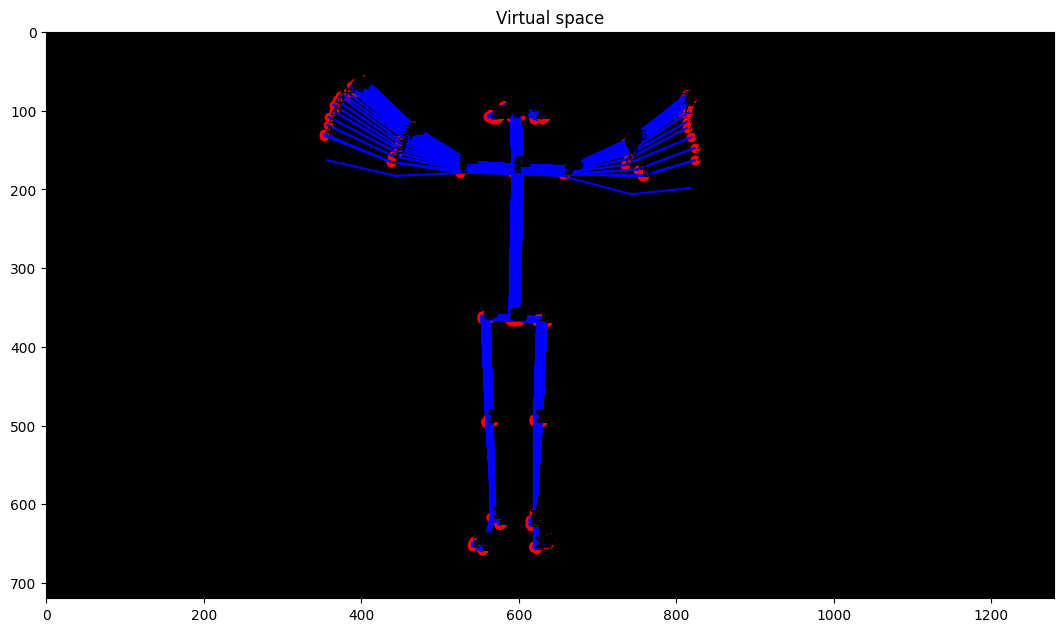

In [27]:
X_Y_C_virtual_space(path_img_json, annotation_list, nb_pers=0)

# 4. Display the distribution of the angles

In [35]:
def X_Y_C_joints(path, dict_joint_position, body_parts, nb_pers):
    '''   
    This functions outputs the coordinates of a .json file or a folder containing .json files.
    The coordinates and angles of each joints/limbs are computed and stored in dataframe X and Y.
    THe columns are the name of the joints and the lines are for each file
    '''
    coor_bp = list(dict_joint_position.values())
    bp_joint = list(dict_joint_position.keys())
    
    if os.path.isdir(path):
        len_filename = len(os.listdir(path))
        arr_joints = np.zeros((len_filename, len(coor_bp)))
        X_df = pd.DataFrame(columns = body_parts)
        Y_df = pd.DataFrame(columns = body_parts)
        for j,filename in enumerate(sorted(os.listdir(path), key=len)):

            list_coord = extract_coord_nb_pers(path,filename, nb_pers)
            X,Y,C = x_y_c(list_coord)
            vect_bp, angle_cos, angle_sin = list_XY_err(coor_bp, X, Y, color='bleu')
            theta = angle(angle_cos, angle_sin)
            dict_angle = angle_joints(bp_joint, theta)

            X_df.loc[len(X_df)] = X
            Y_df.loc[len(Y_df)] = Y
            for i, joints in enumerate(bp_joint):
                arr_joints[j, i] = dict_angle[str(joints)]

        df_joint = pd.DataFrame (arr_joints, columns = bp_joint)
        return df_joint,  arr_joints, (X_df,Y_df,C)

    elif (os.path.isfile(path)):
        dir = os.path.split(path)[0]
        filename = os.path.split(path)[1]
        arr_joints = np.zeros((1, len(coor_bp)))
        list_coord = extract_coord_nb_pers(dir,filename, nb_pers)
        X,Y,C = x_y_c(list_coord, 0)
        vect_bp, angle_cos, angle_sin = list_XY_err(coor_bp, X, Y, color='bleu')
        theta = angle(angle_cos, angle_sin)
        dict_angle = angle_joints(bp_joint, theta)

        for i, joints in enumerate(bp_joint):
            arr_joints[0, i] = dict_angle[str(joints)]

        df_joint = pd.DataFrame (arr_joints, columns = bp_joint)

        return df_joint,  arr_joints, (X,Y,C)

# 5. REFERENCE

In [37]:
# Path to reference pose, .json files
path_ref ='D:\Special_Project\openpose\output_json_folder\Train\Ludo'

       Nose-Neck  Neck-LShoulder  LShoulder-LElbow  LElbow-LWrist  \
count  36.000000       36.000000         36.000000      36.000000   
mean    4.247928       89.338847        116.869998     125.068423   
std     1.331942        1.769159          1.803868       2.541731   
min     1.593556       87.628041        113.604952     121.685175   
25%     3.260345       87.954694        115.511730     123.251037   
50%     4.123162       88.158899        116.538872     124.242358   
75%     4.829655       89.991645        117.742134     126.197369   
max     6.836070       93.991420        122.218311     131.784290   

       Neck-RShoulder  RShoulder-RElbow  RElbow-RWrist  Neck-MidHip  \
count       36.000000         36.000000      36.000000    36.000000   
mean       -92.617873       -117.900956    -127.312491    -1.354164   
std          1.265446          1.705492       2.062491     0.828785   
min        -96.045309       -124.043414    -132.557569    -2.940113   
25%        -93.746267  

<AxesSubplot:>

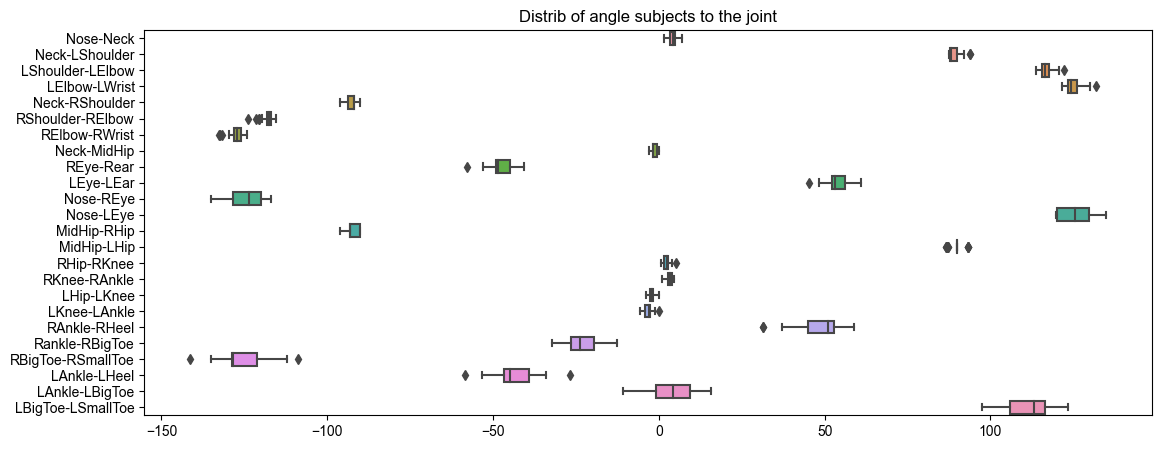

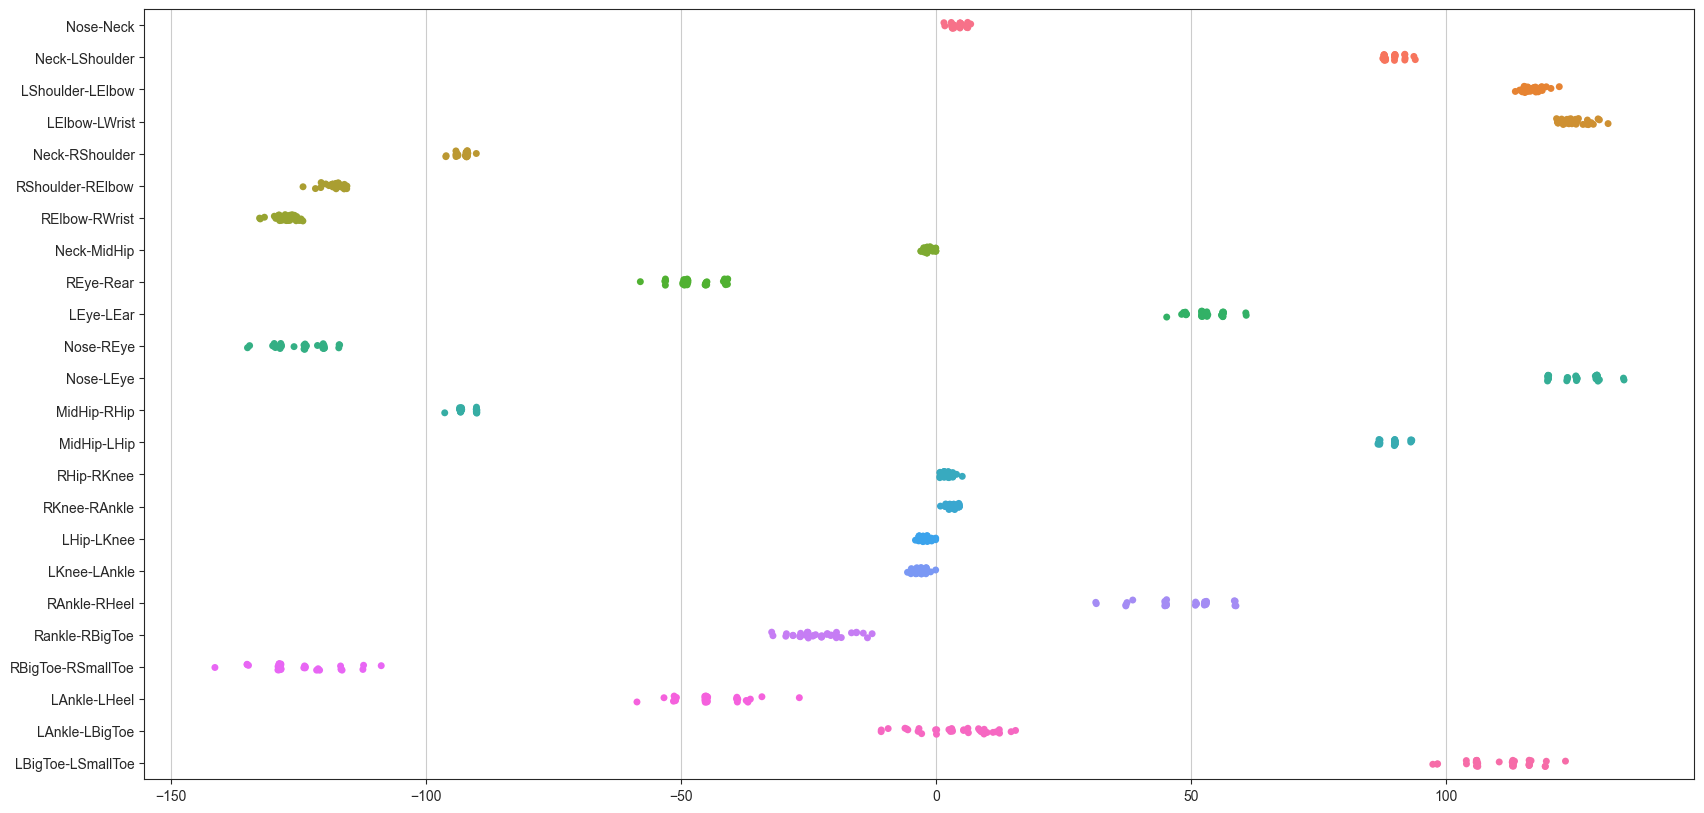

In [38]:
df_joint_ref, _, _= X_Y_C_joints(path_ref, dict_joint_position, body_parts, nb_pers=0)
print(df_joint_ref.describe())


plt.figure(1, figsize=(13,5))
ax = sns.boxplot(data = df_joint_ref, orient = 'h').set(title='Distrib of angle subjects to the joint')
sns.set_style("ticks",{'axes.grid' : True})

plt.figure(2, figsize=(20,10))
sns.stripplot(data = df_joint_ref, orient = 'h')

# 6. UPPER BODY REFERENCE
Upper body reference only computes the variation of angles over the bp_joint_reduced 'body point joint reduced'

In [34]:
bp_joint_reduced = ['Neck-LShoulder', 'LShoulder-LElbow', 'LElbow-LWrist', 'Neck-RShoulder', 'RShoulder-RElbow', 'RElbow-RWrist']
coor_bp_reduced = [[1,5], [5,6], [6,7], [1,2], [2,3], [3,4]]
dict_joint_position_reduced =  {bp_joint_reduced[i]: coor_bp_reduced[i] for i in range(len(bp_joint_reduced))} 

   Neck-LShoulder  LShoulder-LElbow  LElbow-LWrist  Neck-RShoulder  \
0       87.976279        118.616260     125.435422      -90.077190   
1       87.965284        117.542251     130.081916      -92.048433   
2       89.977233        115.466560     122.957430      -92.090022   
3       87.888828        115.071171     123.335018      -93.948686   
4       89.951678        117.583548     124.457293      -91.978274   

   RShoulder-RElbow  RElbow-RWrist  
0       -117.644518    -126.189723  
1       -117.524317    -128.627818  
2       -117.121634    -127.859685  
3       -116.544052    -126.860516  
4       -119.585210    -126.891449  


array([[<AxesSubplot:title={'center':'Neck-LShoulder'}>,
        <AxesSubplot:title={'center':'LShoulder-LElbow'}>],
       [<AxesSubplot:title={'center':'LElbow-LWrist'}>,
        <AxesSubplot:title={'center':'Neck-RShoulder'}>],
       [<AxesSubplot:title={'center':'RShoulder-RElbow'}>,
        <AxesSubplot:title={'center':'RElbow-RWrist'}>]], dtype=object)

<Figure size 640x480 with 0 Axes>

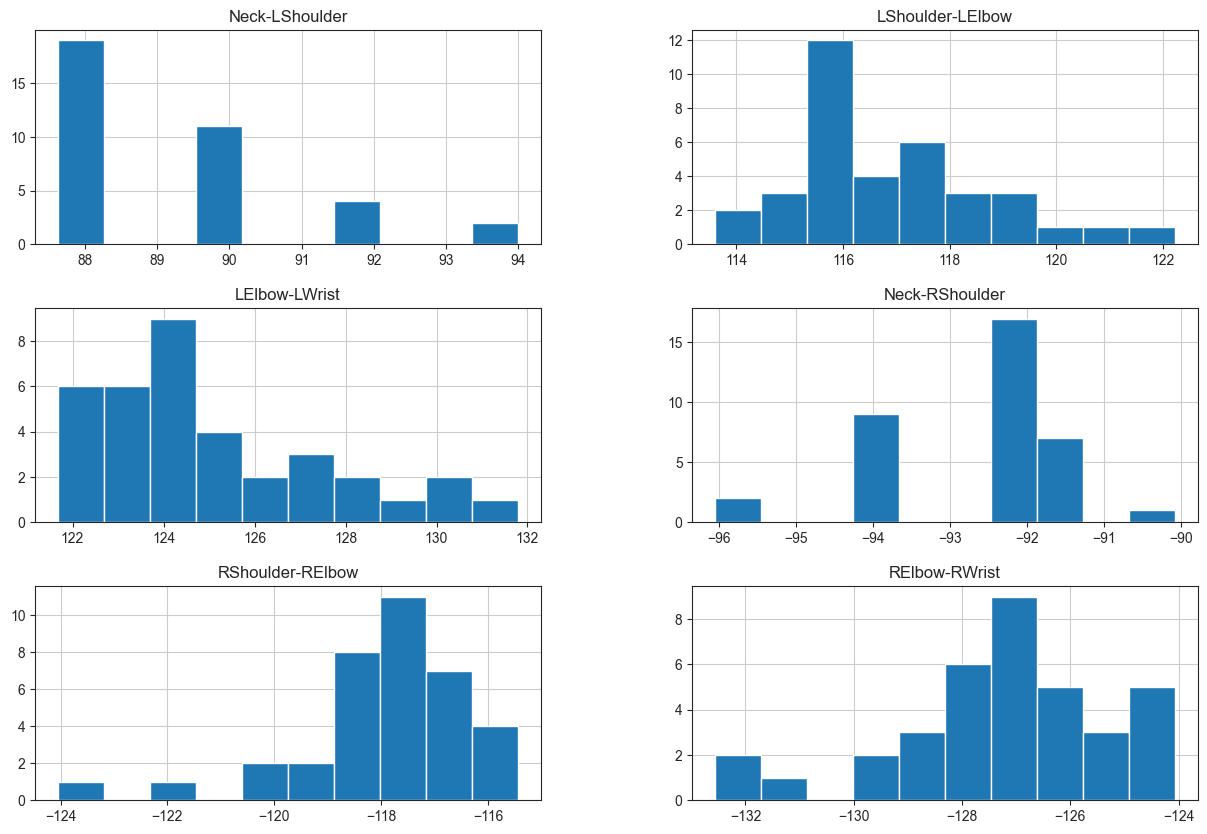

In [44]:
df_joint_ref_reduced, _, _= X_Y_C_joints(path_ref, dict_joint_position_reduced, body_parts, nb_pers=0)
print(df_joint_ref_reduced.head())

df_joint_ref_reduced.hist(bins=10, figsize=(15,10))

# 6. LARGE REPARTITION
Does the distribution of angles can detect an impairement in the reproducibility of the pose by the patient? Try on a patient who has difficulties to reproduce the movement

       Neck-LShoulder  LShoulder-LElbow  LElbow-LWrist  Neck-RShoulder  \
count        7.000000          7.000000       7.000000        7.000000   
mean        86.523790        116.777092     119.548454      -94.119225   
std          1.049533          3.156164       2.300399        1.517003   
min         84.147343        113.215613     116.634890      -95.922830   
25%         86.857519        114.183836     117.422048      -95.634110   
50%         86.885374        115.731958     120.609692      -93.161907   
75%         86.951565        119.734564     121.294605      -92.883519   
max         87.015645        120.655273     122.161290      -92.714583   

       RShoulder-RElbow  RElbow-RWrist  
count          7.000000       7.000000  
mean        -114.883523    -117.821959  
std            2.514328       3.151623  
min         -118.217494    -121.604117  
25%         -116.176947    -120.245125  
50%         -114.983562    -118.345189  
75%         -113.968386    -115.041988  
max  

<AxesSubplot:>

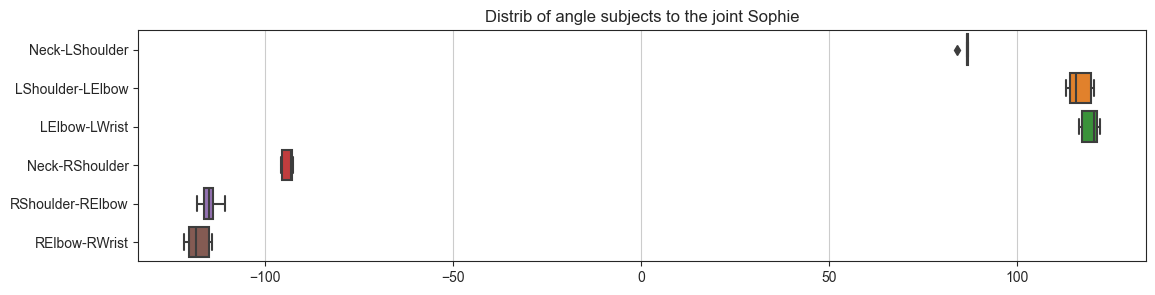

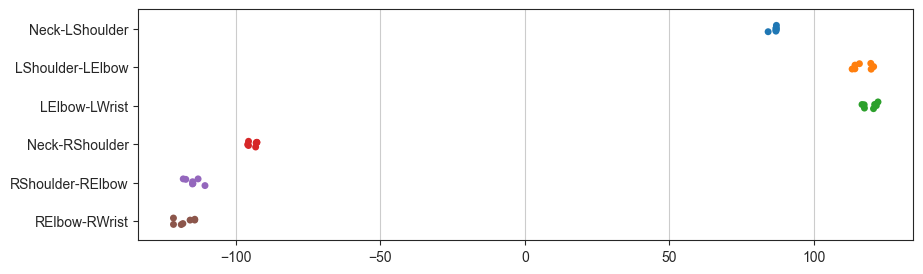

In [47]:
path_Sophie = 'D:\Special_Project\openpose\output_json_folder\Train\Sophie'
df_joint_large, _, _= X_Y_C_joints(path_Sophie, dict_joint_position_reduced, body_parts, nb_pers=0)

print(df_joint_large.describe())

plt.figure(1, figsize=(13,3))
ax = sns.boxplot(data = df_joint_large, orient = 'h').set(title='Distrib of angle subjects to the joint Sophie')
sns.set_style("ticks",{'axes.grid' : True})

plt.figure(2, figsize=(10,3))
sns.stripplot(data = df_joint_large, orient = 'h')


If we compare the statistics of the reference with the statistics of the large repartition datasaet. We assess that the standard deviation if higher in the impaired dataset. We deem that by setting the right threshold, we can discriminate if a pose is reproduced well or not.

# 7. Train the detection to define the statistical parameters

In [48]:
#Define the path to the json dataset in the output folder of OpenPose
path_Train = 'D:\Special_Project\openpose\output_json_folder\Train'

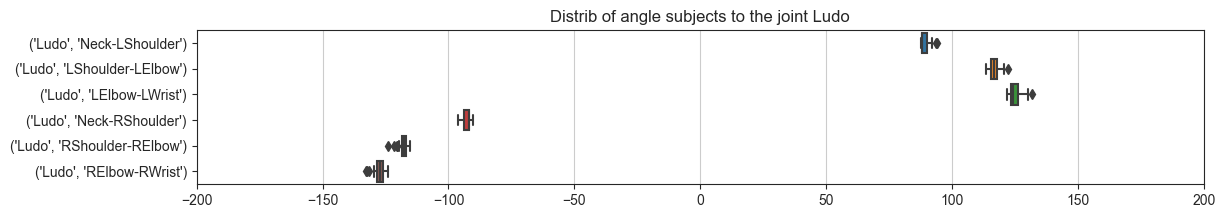

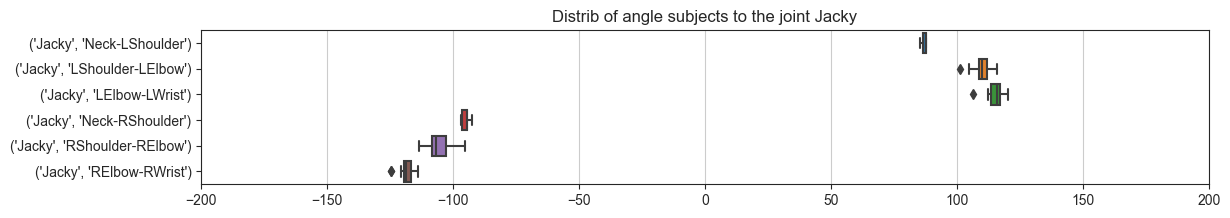

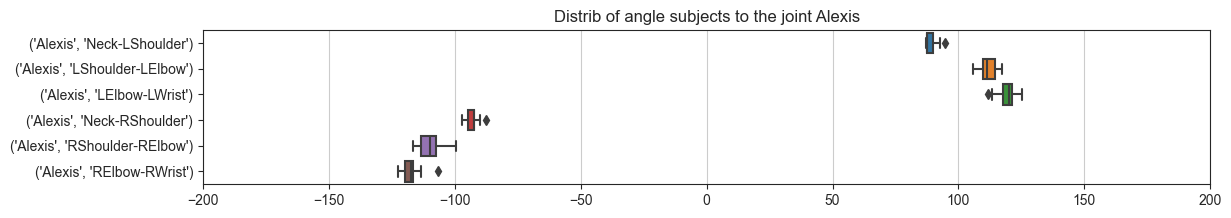

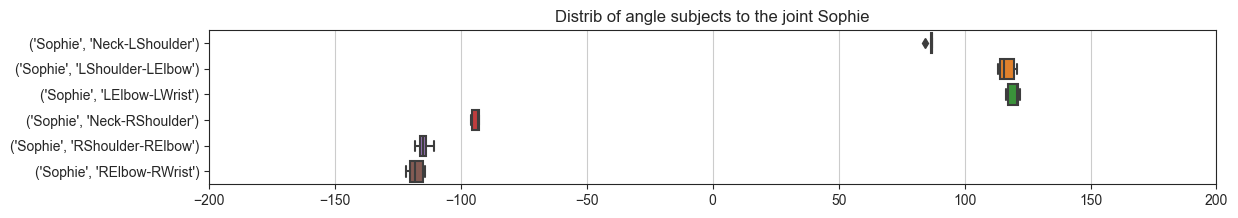

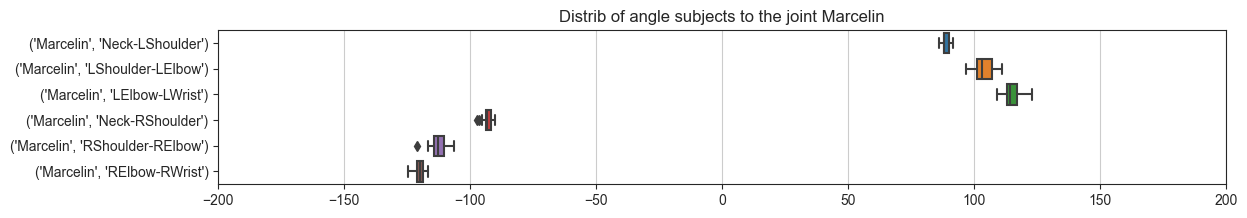

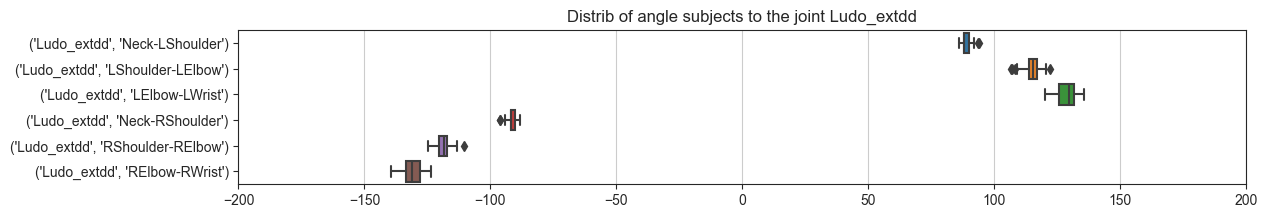

            Ludo                                                \
  Neck-LShoulder LShoulder-LElbow LElbow-LWrist Neck-RShoulder   
0      87.976279       118.616260    125.435422     -90.077190   
1      87.965284       117.542251    130.081916     -92.048433   
2      89.977233       115.466560    122.957430     -92.090022   
3      87.888828       115.071171    123.335018     -93.948686   
4      89.951678       117.583548    124.457293     -91.978274   

                                          Jacky                   \
  RShoulder-RElbow RElbow-RWrist Neck-LShoulder LShoulder-LElbow   
0      -117.644518   -126.189723      87.696374       111.770993   
1      -117.524317   -128.627818      85.246742       115.811791   
2      -117.121634   -127.859685      85.347786       111.778712   
3      -116.544052   -126.860516      87.695240       112.495706   
4      -119.585210   -126.891449      87.575207       109.564401   

                                ...      Marcelin           

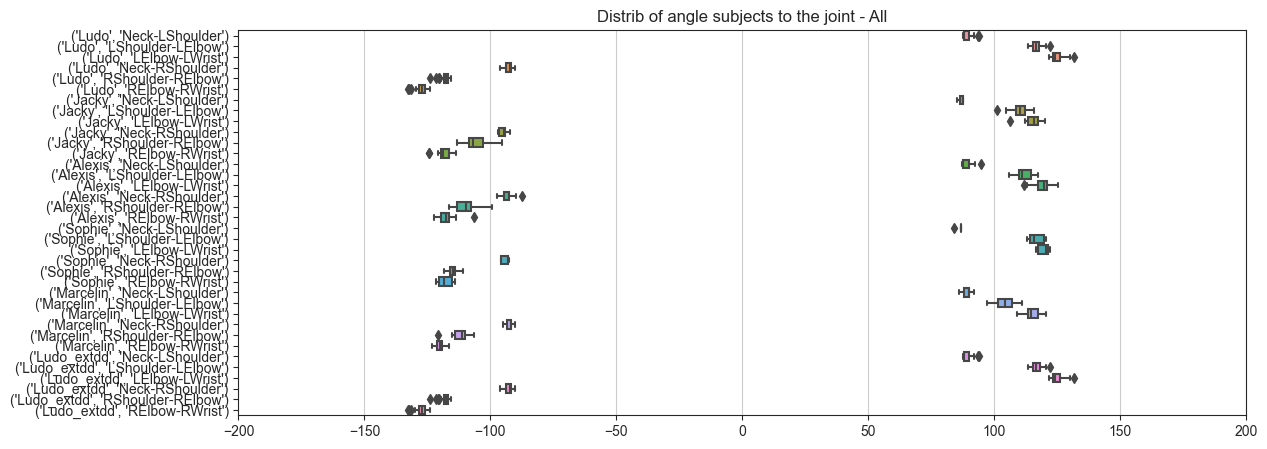

In [54]:
list_folder = sorted(os.listdir(path_Train), key=len)

column = pd.MultiIndex.from_product([list_folder, list(dict_joint_position_reduced)])
df_final = pd.DataFrame(columns=column)
final_list=[]

for k, name in enumerate(list_folder):
    
    path_filename = os.path.join(path_Train, name)
    df_joint, arr_joints, _ = X_Y_C_joints(path_filename, dict_joint_position_reduced, body_parts, nb_pers=0)
    df_joint_reduced = pd.DataFrame(arr_joints, columns=column[k*6:(k+1)*6])

    plt.figure(k, figsize=(13,2))
    ax = sns.boxplot(data = df_joint_reduced, orient = 'h').set(title='Distrib of angle subjects to the joint '+name)
    sns.set_style("ticks",{'axes.grid' : True})
    plt.xlim(-200,200)
    plt.show()

    df_final.loc[:, column[k*6:(k+1)*6]] = df_joint_reduced 

print(df_final.head())
plt.figure(10, figsize=(13,5))
ax = sns.boxplot(data = df_final, orient = 'h').set(title='Distrib of angle subjects to the joint ' + '- All')
sns.set_style("ticks",{'axes.grid' : True})
plt.xlim(-200,200)
plt.show()

    

# 8. A generative model, compare each frame to the reference position

In [63]:
def coor_from_joint(X, Y, joint,i):
    '''   
    The aim is to retrieve the coordinate from the joints using the dictionnary 
    '''
    
    indx2 = dict_joint_position_reduced[joint]
    val_keys = list(annotation_dict.keys())
    key_x0 =val_keys[indx2[0]]
    key_x1 =val_keys[indx2[1]]
    key_y0 =val_keys[indx2[0]]
    key_y1 =val_keys[indx2[1]]

    x0 = X.loc[i, X.columns==key_x0 ][0]
    y0 = Y.loc[i, Y.columns==key_y0 ][0]
    x1 = X.loc[i, X.columns==key_x1 ][0]
    y1 = Y.loc[i, Y.columns==key_y1 ][0]
    return [x0, y0], [x1, y1]

    

In [80]:
def distrib_angle(path_f, dict_joint_position, body_parts, df_ref,im_ref, nb_pers, param1='mean', param2='std', flag=False):
    '''
    Using the dataframe of the angels df_ref, we compute the statistical parameters of each joint in the reference position
    If the frame is with [mean - 3std ; mean + 3std], we deem that this is a correct pose for this position and we label gree
    Otherwise we label green and we define a red arrow if the correction movement is big and blue arrow is it is small.
    The length of the arrows are proportional and in direction to the movement to do to reach the required position
    '''
    coor_bp = list(dict_joint_position.values())
    bp_joint = list(dict_joint_position.keys())
    path_2_json = path_f[0]
    path_2_save = path_f[1]

    df_angle, _, (X,Y,C)= X_Y_C_joints(path_2_json, dict_joint_position,  body_parts, nb_pers)
    df_error = pd.DataFrame(columns = bp_joint)
    for i in range(df_angle.shape[0]):
        
        blank = im_ref
        fig, ax = plt.subplots()
        ax.imshow(blank, cmap='gray')
        ax.set_title('Virtual space')
        annotation_dict_list = list(annotation_dict)
        score=0
        for joint in bp_joint: 
            mean = df_ref.describe().loc[param1, joint]
            std = df_ref.describe().loc[param2, joint]
            angle_joint = df_angle.loc[i, df_angle.columns==joint][0]
            elem = dict_joint_position[joint]
            elem_value = [annotation_dict_list[elem[0]], annotation_dict_list[elem[1]]]

            if (angle_joint > mean-3*std)and(angle_joint < mean+3*std):
                ax.plot([X[elem_value[0]][i], X[elem_value[1]][i]],  [Y[elem_value[0]][i], Y[elem_value[1]][i]] , color='g')
                df_error.at[i, joint] = 0 
                score +=1
            else:
                ax.plot([X[elem_value[0]][i], X[elem_value[1]][i]],  [Y[elem_value[0]][i], Y[elem_value[1]][i]] , color='r')
                df_error.at[i, joint] = angle_joint-(mean-3*std)
                error_angle = angle_joint-(mean-3*std)
                [x0, y0],  [x1, y1] = coor_from_joint(X, Y,joint, i)

                x_arrow, y_arrow = [(x1-x0)/2,(y1-y0)/2 ]
                signe = error_angle/abs(error_angle)
                
                if abs(error_angle)>4:
                    dx = -1*signe*(y1-y0)*abs(error_angle)/30
                    dy = 1*signe*(x1-x0)*abs(error_angle)/30
                    plt.arrow(x0 + x_arrow, y0+ y_arrow,dx, dy, width=10,  head_width=20, head_length=20, color='r' )
                else :
                    dx = -1*signe*(y1-y0)*abs(error_angle)/4
                    dy = 1*signe*(x1-x0)*abs(error_angle)/4
                    plt.arrow(x0 + x_arrow, y0+ y_arrow,dx, dy, width=0.5,  head_width=20, head_length=20, color='b' )

        
        if flag==True:
            plt.tight_layout()
            plt.savefig(os.path.join(path_2_save, str(i) ) + '_' +str(os.path.split(path_2_save)[1]+'.png'))
        plt.close()
    
    return df_error, df_angle, X,Y
    

# 9. Run the detection
Output is each frame/image with the plot of the joints and limbs with the arrows which indicate how to improve the position

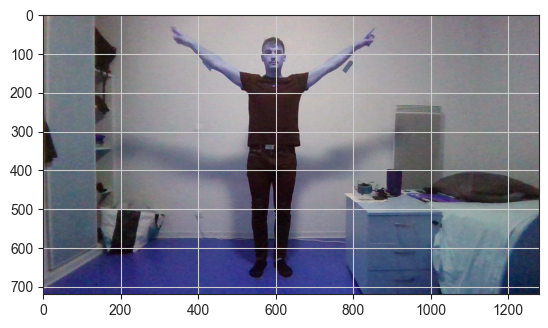

In [84]:
plt.imshow()

In [85]:
path_2_json =r'D:\Special_Project\Dataset\Output\Show\Trim'
path_2_AR =r'D:\Special_Project\Dataset\Output\Test'
im_ref = plt.imread(path_image_wall)
path_f = [path_2_json, path_2_AR]

In [87]:
df_error, df_angle, X, Y = distrib_angle(path_f, dict_joint_position_reduced, body_parts,  df_joint_ref_reduced, im_ref, nb_pers=0, param1='mean', param2='std', flag=True)

# 10. Video save and display

In [ ]:
# Define path_film to merge all the figures save in 9 into a movie
path_film = r'D:\Special_Project\Dataset\Output\Show\Final'
name_video = 'Ludovideo'

In [32]:
def write_video(path_2_file, name_video):
    image_folder = path_2_file
    video_name = name_video + '.avi'
    images = [img for img in sorted(os.listdir(image_folder), key=len) if img.endswith(".png")]
    
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(os.path.join(path_2_file, video_name), 0, 4, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(path_2_file, image)))
    cv2.destroyAllWindows()
    video.release()

In [34]:
write_video(path_film, name_video)